#### Import data and librarys

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [2]:
df = pd.read_csv("agg.csv")

#### Model

In [3]:
df["updated_at"] = pd.to_datetime(df["updated_at"])
df = df.sort_values(["number", "updated_at"])
df["ratio"] = df["available_to_total_ratio"].astype(float)
df["hour"] = df["updated_at"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["minute"] = df["updated_at"].dt.minute
df["weekday_num"] = df["updated_at"].dt.weekday
df["is_weekend"] = (df["is_weekend"].astype(str).str.strip().str.lower().replace({"false": 0, "true": 1}))
df["is_weekend"] = df["is_weekend"].fillna(0)
df["is_weekend"] = df["is_weekend"].astype(int)

C:\Users\Simon\AppData\Local\Temp\ipykernel_24620\851586395.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_weekend"] = (df["is_weekend"].astype(str).str.strip().str.lower().replace({"false": 0, "true": 1}))


In [4]:
LAG_STEPS = 12   # Use the past 12 time steps (e.g., 2 hours if data is 10-minutely)
PRED_OFFSET = 1  # Predict 1 step ahead (e.g., the next 10 minutes)

def create_time_series_features(df, lag_steps, pred_offset):
    # 1. Create Lagged Features (X)
    df_features = df[['ratio', 'geo_point_2d.lon', 'geo_point_2d.lat', 
                      'hour_sin', 'hour_cos', 'weekday_num', 'is_weekend']].copy()
    
    for i in range(1, lag_steps + 1):
        # Create a lagged column for the 'ratio'
        df_features[f'ratio_lag_{i}'] = df_features['ratio'].shift(i)
        
        # Optional: Add lags for other key features if desired (omitted here for simplicity)
        
    # 2. Create Target Variable (Y)
    # The target is the bike ratio 'PRED_OFFSET' steps into the future
    df_features['target_ratio'] = df_features['ratio'].shift(-pred_offset)
    
    # Drop rows with NaN values introduced by shifting (first 'LAG_STEPS' rows and the last 'PRED_OFFSET' rows)
    df_features.dropna(inplace=True)
    
    # Define features (X) and target (Y)
    # X will now include all engineered time features (sin/cos, weekday, weekend) 
    # and all the new lagged ratio columns.
    
    # We must exclude the original 'ratio' and the 'target_ratio' from the features (X)
    X = df_features.drop(columns=['ratio', 'target_ratio']).values
    Y = df_features['target_ratio'].values
    
    return X, Y

X_list, y_list = [], []

for station_id, g in df.groupby("number"):
    Xi, yi = create_time_series_features(g, LAG_STEPS, PRED_OFFSET)
    X_list.append(Xi)
    y_list.append(yi)

X = np.vstack(X_list)
y = np.concatenate(y_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

y_train = y_train.ravel()
y_test = y_test.ravel()

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (78240, 18), y_train shape: (78240,)
X_test shape: (19560, 18), y_test shape: (19560,)


#### Definition and Training

In [5]:
# Create and train the Random Forest Regressor model
# Note: n_estimators, max_depth, and other parameters should be tuned
model = RandomForestRegressor(n_estimators=100, max_depth=15, 
                              random_state=42, n_jobs=-1, verbose=1)

print("Starting Random Forest Model Training...")
# Training the model
model.fit(X_train, y_train) 
print("Training Complete.")

# Evaluate the model on the test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R-squared: {r2:.4f}")

# Save the model
joblib.dump(model, "random_forest_bike_prediction_model.joblib")
print("Model saved to random_forest_bike_prediction_model.joblib")

Starting Random Forest Model Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Complete.
Test RMSE: 0.0853
Test MAE: 0.0533
Test R-squared: 0.9394
Model saved to random_forest_bike_prediction_model.joblib
Model saved to random_forest_bike_prediction_model.joblib


#### Use historical data to predict the next 24 hours

In [6]:
import matplotlib.pyplot as plt

def predict_next_24_hours(station, model, lag_steps=LAG_STEPS, pred_offset=PRED_OFFSET):
    """
    Predict the next 24 hours for a given station using the Random Forest model.
    Uses lagged features consistent with training.
    """
    df1 = df[df["number"] == station].copy()
    df1 = df1.sort_values("updated_at")
    
    if len(df1) < lag_steps + 1:
        print(f"Not enough data for station {station}")
        return [], [], [], []
    
    # Get historical data for feature extraction
    df_hist = df1.iloc[:-lag_steps].copy() if len(df1) > lag_steps else df1.copy()
    df_future = df1.iloc[-lag_steps:].copy() if len(df1) > lag_steps else df1.copy()
    
    preds = []
    
    # Create lagged features from historical data
    df_features = df_hist[['ratio', 'geo_point_2d.lon', 'geo_point_2d.lat', 
                           'hour_sin', 'hour_cos', 'weekday_num', 'is_weekend']].copy()
    
    for i in range(1, lag_steps + 1):
        df_features[f'ratio_lag_{i}'] = df_features['ratio'].shift(i)
    
    df_features.dropna(inplace=True)
    
    if len(df_features) == 0:
        return [], [], [], []
    
    # Get feature columns (same as training)
    feature_cols = ['geo_point_2d.lon', 'geo_point_2d.lat', 
                   'hour_sin', 'hour_cos', 'weekday_num', 'is_weekend']
    for i in range(1, lag_steps + 1):
        feature_cols.append(f'ratio_lag_{i}')
    
    # Initialize current feature vector with the last complete row
    current_features_vector = df_features[feature_cols].iloc[-1].values
    
    baseline_ratio = df_hist["ratio"].mean()
    baseline_preds_ratio = np.ones(len(df_future)) * baseline_ratio
    
    # Autoregressive prediction
    for i in range(len(df_future)):
        pred = model.predict(current_features_vector.reshape(1, -1))[0]
        preds.append(pred)
        
        # Shift lag features for next iteration
        new_features = current_features_vector.copy()
        # Shift all lags: lag_i becomes lag_(i+1), and new prediction becomes lag_1
        for j in range(lag_steps - 1, 0, -1):
            new_features[5 + j] = new_features[5 + j - 1]  # geo features end at index 5
        new_features[5] = pred  # ratio_lag_1 is at index 5 (after geo + time features)
        
        current_features_vector = new_features
    
    true_ratio = df_future["ratio"].values[:len(preds)]
    times = df_future["updated_at"].values[:len(preds)]
    
    return preds, true_ratio, times, baseline_preds_ratio

def calculate_metrics(preds, true_ratio):
    """Calculate evaluation metrics for predictions."""
    mae = mean_absolute_error(true_ratio, preds)
    rmse = np.sqrt(mean_squared_error(true_ratio, preds))
    r2 = r2_score(true_ratio, preds)
    return mae, rmse, r2

def plot_predictions(station, preds, true_ratio, times, baseline_preds_ratio):
    """Plot predictions vs observations."""
    plt.figure(figsize=(12, 5))
    plt.plot(times, true_ratio, label="Observations (ratio)")
    plt.plot(times, preds, label="Random Forest Prediction", linestyle="--")
    plt.plot(times, baseline_preds_ratio, label="Baseline", linestyle=":")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Ratio available bikes")
    plt.title(f"Station {station}: Random Forest vs Baseline")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0

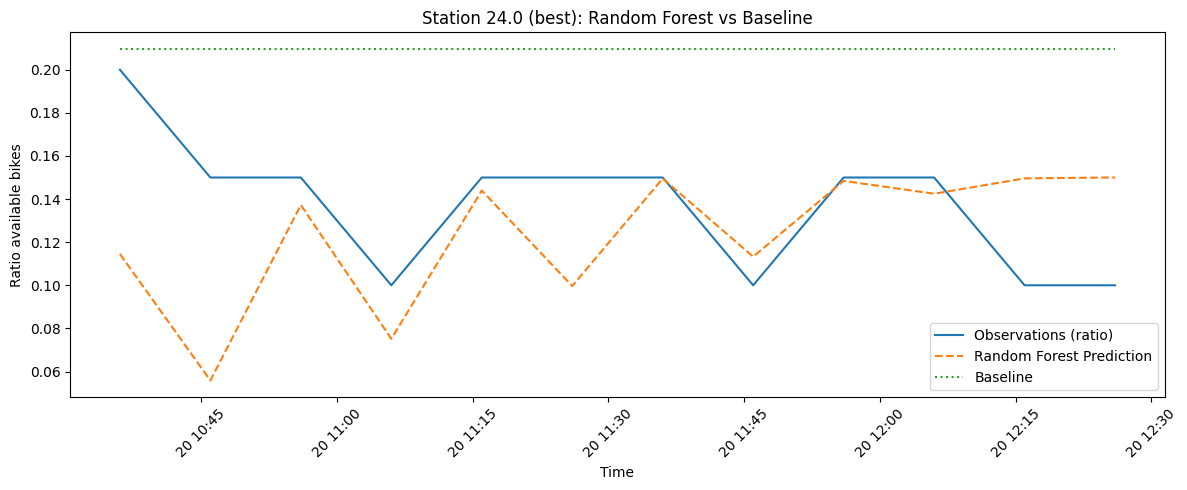

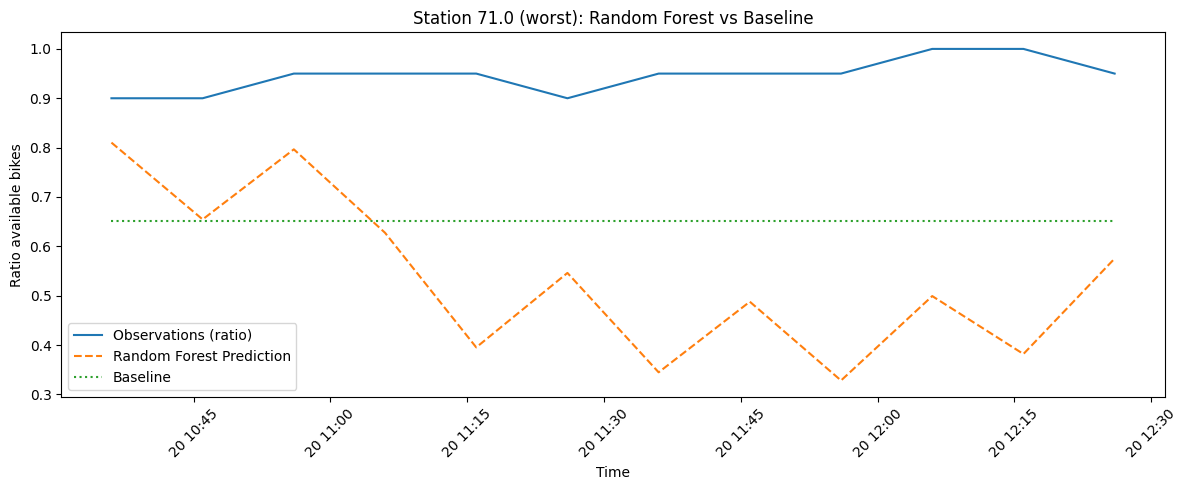

Overall MAE for best station 24.0: 0.0454
Overall MAE for worst station 71.0: 0.4444


In [8]:
results_df = pd.DataFrame() # Initialize an empty DataFrame

for station in df["number"].unique():
    preds, true_ratio, times, baseline_preds_ratio = predict_next_24_hours(station, model)
    mae, rmse, r2 = calculate_metrics(preds, true_ratio)

    # Create a temporary DataFrame for the current station's predictions
    # Each row will correspond to a single time step within the prediction window
    temp_df = pd.DataFrame({
        "station": [station] * len(preds), # Repeat station ID for each prediction step
        "preds": preds,
        "true": true_ratio,
        "times": times,
        "baseline": baseline_preds_ratio,
        "mae": [mae] * len(preds), # Repeat metrics for each prediction step
        "rmse": [rmse] * len(preds),
        "r2": [r2] * len(preds)
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Now, results_df has multiple rows per station, each representing a prediction at a specific time.
# To find the best/worst station, we group by station and consider the calculated metrics.
# Since mae, rmse, r2 are already stored for each row of a station, we can simply get the first occurrence for each station.
station_metrics = results_df.drop_duplicates(subset=['station'])[['station', 'mae', 'rmse', 'r2']]

best_station_row = station_metrics.loc[station_metrics["rmse"].idxmin()]
worst_station_row = station_metrics.loc[station_metrics["rmse"].idxmax()]

best_station_id = best_station_row["station"]
worst_station_id = worst_station_row["station"]

# Filter the original results_df to get all prediction data for the best and worst stations
best_plot_data = results_df[results_df["station"] == best_station_id]
worst_plot_data = results_df[results_df["station"] == worst_station_id]

# Plotting the predictions for the best and worst performing stations
plot_predictions(f"{best_station_id} (best)",
                 best_plot_data["preds"].values,
                 best_plot_data["true"].values,
                 best_plot_data["times"].values,
                 best_plot_data["baseline"].values)

plot_predictions(f"{worst_station_id} (worst)",
                 worst_plot_data["preds"].values,
                 worst_plot_data["true"].values,
                 worst_plot_data["times"].values,
                 worst_plot_data["baseline"].values)

print(f"Overall MAE for best station {best_station_id}: {best_station_row['rmse']:.4f}")
print(f"Overall MAE for worst station {worst_station_id}: {worst_station_row['rmse']:.4f}")

In [9]:
station_coords = df[['number', 'geo_point_2d.lat', 'geo_point_2d.lon']].drop_duplicates()

merged_data = pd.merge(station_coords, station_metrics, left_on='number', right_on='station', how='inner')

print("Station Coordinates:")
print(station_coords.head())
print("\nMerged Data with Coordinates and Metrics:")
print(merged_data.head())

Station Coordinates:
   number  geo_point_2d.lat  geo_point_2d.lon
0       1         39.480042         -0.382929
1       2         39.479889         -0.379748
2       3         39.476835         -0.380288
3       4         39.476747         -0.375342
4       5         39.476895         -0.371140

Merged Data with Coordinates and Metrics:
   number  geo_point_2d.lat  geo_point_2d.lon  station       mae      rmse  \
0       1         39.480042         -0.382929        1  0.089931  0.101082   
1       2         39.479889         -0.379748        2  0.082581  0.094867   
2       3         39.476835         -0.380288        3  0.034116  0.052894   
3       4         39.476747         -0.375342        4  0.124122  0.142008   
4       5         39.476895         -0.371140        5  0.120519  0.138407   

          r2  
0 -11.261064  
1  -0.375442  
2  -0.310198  
3 -29.761962  
4  -2.103349  


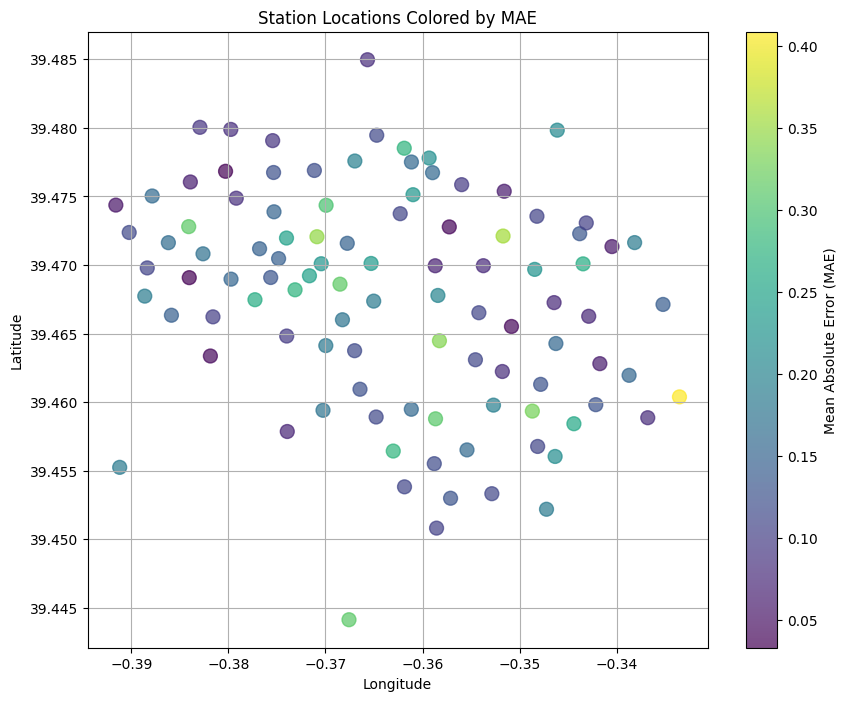

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(merged_data['geo_point_2d.lon'], merged_data['geo_point_2d.lat'],
                      c=merged_data['mae'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Mean Absolute Error (MAE)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station Locations Colored by MAE')
plt.grid(True)
plt.show()

In [11]:
import folium

# Calculate the center of the map based on the average coordinates
center_lat = merged_data['geo_point_2d.lat'].mean()
center_lon = merged_data['geo_point_2d.lon'].mean()

# Create a Folium map centered at the average coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Normalize MAE for color and size scaling
# Using a min-max scaler to normalize MAE between 0 and 1
min_mae = merged_data['mae'].min()
max_mae = merged_data['mae'].max()

# Add CircleMarkers for each station
for idx, row in merged_data.iterrows():
    # Scale MAE for color (e.g., green for low MAE, red for high MAE)
    # Using a simple linear interpolation for color based on MAE
    norm_mae = (row['mae'] - min_mae) / (max_mae - min_mae) if (max_mae - min_mae) > 0 else 0
    color = plt.cm.viridis(norm_mae) # Get color from viridis colormap
    # Convert RGBA to hex for Folium
    hex_color = '#%02x%02x%02x' % (int(color[0]*255), int(color[1]*255), int(color[2]*255))

    folium.CircleMarker(
        location=[row['geo_point_2d.lat'], row['geo_point_2d.lon']],
        radius=5,
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
        tooltip=f"Station: {int(row['station'])}, MAE: {row['mae']:.4f}"
    ).add_to(m)

# Display the map
m

In [ ]:
# Model already saved during training as "random_forest_bike_prediction_model.joblib"
# To load it later, use:
# model = joblib.load("random_forest_bike_prediction_model.joblib")
print("Model saved as random_forest_bike_prediction_model.joblib during training")
